In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 336.8 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116951 sha256=34076ce383046c8e47b4afd468ced064a0b2e4f73ac23542ca0cbc9d0d22debb
  Stored in directory: /Users/liuyanlinsnp/Library/Caches/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


In [1]:
!pip install shap

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import shap

import medmnist
from medmnist import INFO, Evaluator

: 

# Work on a 2D dataset





In [14]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.0015

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [15]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

In [ ]:
# visualization

train_dataset.montage(length=1).info()

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


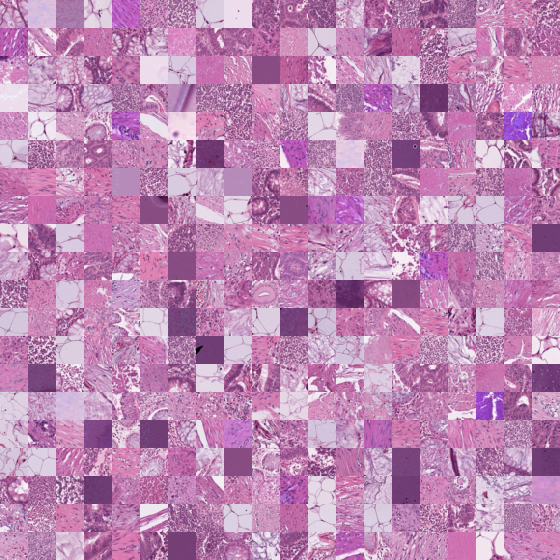

In [ ]:
# montage

train_dataset.montage(length=20)


## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [16]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [18]:
# train

train_loss_list = []
test_loss_list = []
train_auc_list = []
train_acc_list = []
test_auc_list = []
test_acc_list = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0  # 初始化用于累积损失的变量
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # 累积损失

    # 计算并存储每个 epoch 的平均训练损失
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    # 评估模型并收集指标
    train_auc, train_acc = test('train')
    test_auc, test_acc, avg_loss = test('test')

    # 将指标添加到列表中
    train_auc_list.append(train_auc)
    train_acc_list.append(train_acc)
    test_auc_list.append(test_auc)
    test_acc_list.append(test_acc)

    test_loss_list.append(avg_loss)


100%|██████████| 704/704 [02:54<00:00,  4.02it/s]


In [17]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    total_loss = 0.0

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)
            
            # 计算损失，这里需要根据实际情况选择合适的损失函数
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        
        avg_loss = total_loss / len(data_loader)
        #print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        return metrics.AUC, metrics.ACC, avg_loss

#print('==> Evaluating ...')
#test('train')
#test('test')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

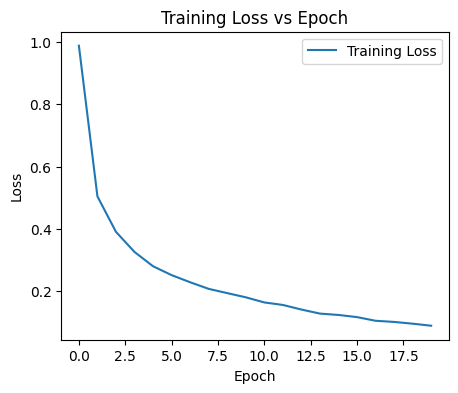

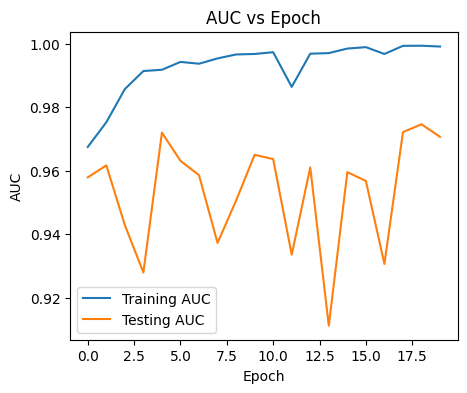

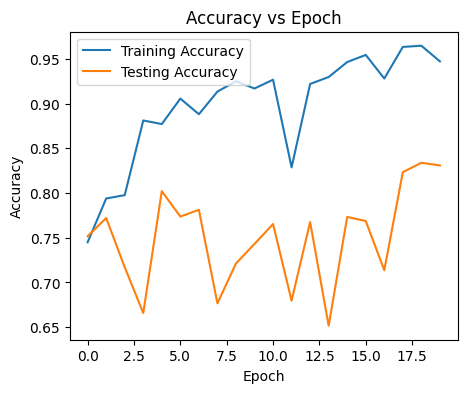

In [20]:
# 绘制损失图
plt.figure(figsize=(5, 4))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

# 绘制 AUC 图
plt.figure(figsize=(5, 4))
plt.plot(train_auc_list, label='Training AUC')  # 直接使用 train_auc_list
plt.plot(test_auc_list, label='Testing AUC')    # 直接使用 test_auc_list
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC vs Epoch')
plt.legend()
plt.show()

# 绘制准确率图
plt.figure(figsize=(5, 4))
plt.plot(train_acc_list, label='Training Accuracy')  # 使用 train_acc_list
plt.plot(test_acc_list, label='Testing Accuracy')    # 使用 test_acc_list
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()


# SHAP


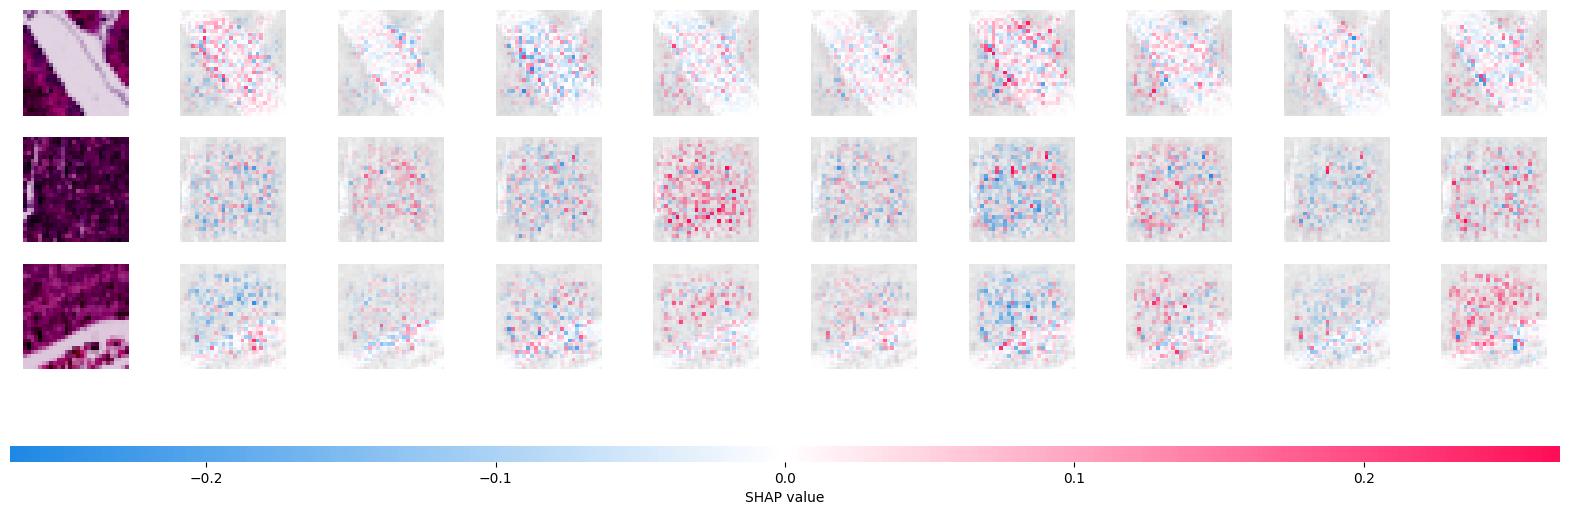

In [21]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch = next(iter(train_loader))
images, labels = batch

background = images[:61].to(device)
test_images = images[61:64].to(device)
model.to(device)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)


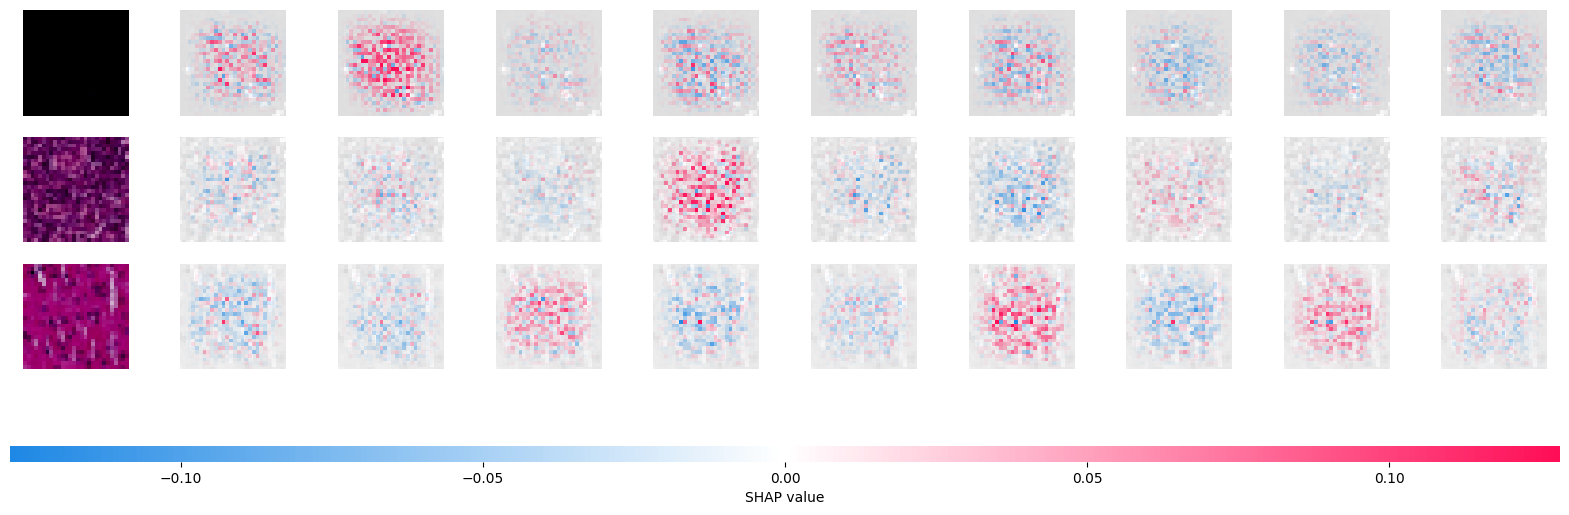

<Figure size 640x480 with 0 Axes>

In [12]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch = next(iter(train_loader))
images, labels = batch

background = images[:61].to(device)
test_images = images[61:64].to(device)
model.to(device)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)


# 获取模型的预测结果
preds = model(test_images)
predicted_classes = preds.argmax(dim=1)

# 将预测结果和实际标签转换为CPU上的numpy数组
predicted_classes = predicted_classes.cpu().numpy()
true_labels = labels[61:64].cpu().numpy()

# 计算SHAP值并进行转换以用于绘图
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# 绘制特征归因图
shap.image_plot(shap_numpy, test_numpy)

# 获取当前图像和轴的引用
fig = plt.gcf()
axes = fig.get_axes()

# 为每个测试图像添加预测和实际标签
for i, ax in enumerate(axes):
    if i % len(shap_values) == 0:  # 只在每行的第一个subplot（即原始图像）后添加标签
        ax.text(ax.get_xlim()[1], ax.get_ylim()[0], f'Predicted: {predicted_classes[i//len(shap_values)]}, True: {true_labels[i//len(shap_values)]}',
                verticalalignment='bottom', horizontalalignment='right', fontsize=8, color='white')

plt.show()

In [3]:
d={[1]:1}

TypeError: unhashable type: 'list'

In [5]:
train_loss_list = [1,23,6,5]
test_loss_list = [1,23,6,5]
train_auc_list = [1,23,6,5]
train_acc_list = [1,23,6,5]
test_auc_list = [1,23,6,5]
test_acc_list = [1,23,6,5]

print('train-acc:{}  test-acc:{}\ntrain-auc:{}  test-auc:{}'.format(train_acc_list[-1],test_acc_list[-1],train_auc_list[-1],test_auc_list[-1]))

train-acc:5  test-acc:5
train-auc:5  test-auc:5
